In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install tensorflow keras opencv-python pandas scikit-learn kaggle

In [7]:
import os
# Membuat folder .kaggle dan memindahkan file kaggle.json ke folder tersebut
os.makedirs('/root/.kaggle', exist_ok=True)
# Ganti dengan path ke file kaggle.json yang telah diunggah ke Colab
!cp /content/kaggle.json /root/.kaggle/

# Mengatur permission file agar dapat digunakan
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
# Mengunduh dataset FER2013 dari Kaggle
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 96% 58.0M/60.3M [00:03<00:00, 24.1MB/s]
100% 60.3M/60.3M [00:03<00:00, 17.1MB/s]


In [9]:
# Mengekstrak file ZIP dataset
!unzip fer2013.zip -d /content/fer2013

Streaming output truncated to the last 5000 lines.
  inflating: /content/fer2013/train/sad/Training_65242339.jpg  
  inflating: /content/fer2013/train/sad/Training_65267116.jpg  
  inflating: /content/fer2013/train/sad/Training_65275626.jpg  
  inflating: /content/fer2013/train/sad/Training_6529266.jpg  
  inflating: /content/fer2013/train/sad/Training_65329617.jpg  
  inflating: /content/fer2013/train/sad/Training_65338712.jpg  
  inflating: /content/fer2013/train/sad/Training_65338797.jpg  
  inflating: /content/fer2013/train/sad/Training_65387162.jpg  
  inflating: /content/fer2013/train/sad/Training_65404494.jpg  
  inflating: /content/fer2013/train/sad/Training_65426218.jpg  
  inflating: /content/fer2013/train/sad/Training_65430136.jpg  
  inflating: /content/fer2013/train/sad/Training_65437377.jpg  
  inflating: /content/fer2013/train/sad/Training_6545735.jpg  
  inflating: /content/fer2013/train/sad/Training_65463385.jpg  
  inflating: /content/fer2013/train/sad/Training_654739

In [11]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# Menentukan label emosi
emotion_dict = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

# Menyiapkan data untuk pelatihan dan pengujian
X_train, y_train = [], []
X_test, y_test = [], []

# Menentukan jalur direktori untuk folder pelatihan dan pengujian
train_dir = '/content/fer2013/train/'
test_dir = '/content/fer2013/test/'

# Fungsi untuk memproses gambar dari sebuah direktori
def load_images_from_directory(directory):
    X = []
    y = []
    for emotion_idx, emotion in emotion_dict.items():
        emotion_folder = os.path.join(directory, emotion)

        # Memeriksa apakah folder emosi ada
        if os.path.exists(emotion_folder):
            # Melakukan iterasi pada setiap file gambar dalam folder emosi
            for image_file in os.listdir(emotion_folder):
                image_path = os.path.join(emotion_folder, image_file)

                # Membaca gambar dan mengkonversinya ke grayscale
                img = cv2.imread(image_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Mengubah ukuran gambar menjadi 48x48 dan menormalisasi
                gray = cv2.resize(gray, (48, 48))
                gray = np.expand_dims(gray, axis=-1)  # Menambahkan dimensi channel
                gray = gray / 255.0  # Normalisasi ke rentang [0, 1]

                # Menambahkan data gambar dan label emosi yang sesuai
                X.append(gray)
                y.append(emotion_idx)

    return np.array(X), np.array(y)

# Memuat gambar dan label untuk data pelatihan dan pengujian
X_train, y_train = load_images_from_directory(train_dir)
X_test, y_test = load_images_from_directory(test_dir)

# Menampilkan bentuk (shape) dari data pelatihan dan pengujian
print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")


Training Data Shape: (28709, 48, 48, 1), Testing Data Shape: (7178, 48, 48, 1)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Membuat model CNN untuk deteksi ekspresi wajah
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(7, activation='softmax')  # 7 kelas ekspresi (Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral)
])

# Menyusun model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Melihat ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,762,375 (33.43 MB)

 Trainable params: 8,762,375 (33.43 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Melatih model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Menyimpan model setelah pelatihan selesai
model.save('/content/drive/MyDrive/face_analysis_project/models/emotion_model.h5')

Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.2888 - loss: 1.7469 - val_accuracy: 0.4618 - val_loss: 1.4045
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4796 - loss: 1.3622 - val_accuracy: 0.5008 - val_loss: 1.2919
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5529 - loss: 1.1790 - val_accuracy: 0.5364 - val_loss: 1.2253
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6163 - loss: 1.0207 - val_accuracy: 0.5453 - val_loss: 1.2389
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6928 - loss: 0.8263 - val_accuracy: 0.5580 - val_loss: 1.2893
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7921 - loss: 0.5960 - val_accuracy: 0.5510 - val_loss: 1.4507
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8716 - loss: 0.3871 - val_accuracy: 0.5651 - val_loss: 1.7249
Epoch 8/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9208 - loss: 0.2369 - val_accuracy

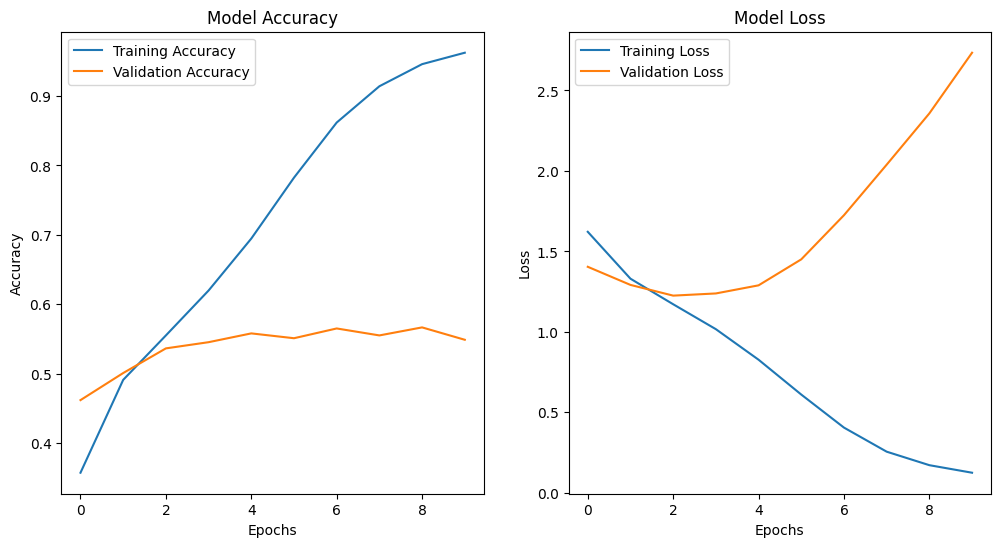

In [14]:
import matplotlib.pyplot as plt

# Plot akurasi training dan validasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss training dan validasi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
# Model disimpan di Google Drive setelah pelatihan selesai
model.save('/content/drive/MyDrive/face_analysis_project/models/emotion_model.h5')

In [22]:
import numpy as np
from tensorflow.keras.models import load_model

# Memuat model .h5
model = load_model('/content/drive/MyDrive/face_analysis_project/models/emotion_model.h5')

# 1. Memeriksa struktur arsitektur model
print("Model Summary:")
model.summary()  # Menampilkan struktur model (lapisan-lapisan, bentuk data, jumlah parameter)

# 2. Mendapatkan informasi lebih lanjut tentang bobot model
weights = model.get_weights()  # Mendapatkan bobot-bobot model
print("\nJumlah Lapisan (Layer) dalam Model:", len(weights))  # Menampilkan jumlah lapisan

# 3. Menampilkan bobot pertama untuk memahami lebih jauh
# Contoh: menampilkan bobot dari lapisan pertama (biasanya Conv2D atau Dense)
if len(weights) > 0:
    print("\nBobot Lapisan Pertama:")
    print(np.array(weights[0]))  # Menampilkan bobot lapisan pertama, ini berupa matriks atau tensor
else:
    print("\nModel tidak memiliki bobot atau bobot kosong.")


Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,762,377 (33.43 MB)

 Trainable params: 8,762,375 (33.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Jumlah Lapisan (Layer) dalam Model: 10

Bobot Lapisan Pertama:
[[[[ 2.09365729e-02  9.62584540e-02 -5.94074130e-02 -1.66633382e-01
    -6.02081642e-02  6.78085834e-02  1.19051494e-01  1.87327564e-01
    -7.40534663e-02  1.63735271e-01  1.02097459e-01 -2.48299301e-01
     1.52979478e-01  2.31312171e-01 -1.18489742e-01 -2.27760136e-01
    -6.93979636e-02 -7.72114769e-02 -1.64946597e-02 -2.02625170e-01
     1.54405460e-01 -1.61267906e-01 -2.60456167e-02 -3.30951512e-02
    -5.59643693e-02  1.30462674e-02 -1.42400146e-01  3.53771076e-02
    -4.56720665e-02 -7.03174323e-02  1.90110549e-01  3.92781757e-02
     1.42955124e-01 -2.57828444e-01 -2.61287153e-01 -7.37499222e-02
     1.59980893e-01 -2.31220983e-02  7.85196573e-02  3.05846512e-01
     2.42599174e-01 -1.97694898e-02 -3.70476283e-02  2.96169758e-01
     8.30679014e-02  1.76836830e-02 -2.03136131e-01 -1.69641435e-01
     8.79861712e-02 -1.57047391e-01 -4.89433371e-02  2.03076601e-01
    -1.64870508e-02  3.42458226e-02 -2.16862768e-01 